In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports and default values

In [55]:
import numpy as np
from numpy import cos, sin
from numpy.linalg import inv as matinv
from numpy.linalg import multi_dot
from scipy.optimize import minimize
from scipy.linalg import block_diag
from easydict import EasyDict as edict
import matplotlib.pyplot as plt

from util import plot_cov

DELTA_T = 0.1
CAM_HEIGHT = 0.0
FX = 1.0
FY = 1.0
PX = 0
PY = 0
PROCESS_NOISE_COV = np.diag([0.0001,0.0001,0.0001]) # robot pose, (x,y,theta)
OBS_NOISE_COV = np.diag([0.01,0.01]) # pixel coord, (ux, uy)
POSE_DIM = 3
SCENE_PT_DIM = 3
CTRL_WEIGHT = 0*np.diag([1.0,1.0,1.0])

### SymPy Definitions

In [56]:
from sympy import symbols, Matrix, BlockMatrix, lambdify
from sympy import cos as c
from sympy import sin as s
from sympy import diff
xr, yr, t, xs, ys, zs = symbols("x_r y_r \\theta X_s Y_s Z_s")
hc = symbols("h_c")
fx, fy, px, py = symbols("f_x f_y p_x p_y")

Rrobot = Matrix([[c(t), -s(t), 0],
                 [s(t),  c(t), 0],
                 [0,     0,    1]])
trobot = Matrix([[xr],[yr],[0]])
tmp = Matrix(BlockMatrix([Rrobot,trobot]))
Trobot = Matrix([[tmp],[0,0,0,1]])

tmp = Matrix(BlockMatrix([Rrobot.transpose(),-Rrobot.transpose()*trobot]))
Trobot_inv = Matrix([[tmp],[0,0,0,1]])

Rbc = Matrix([[0,  0, 1],
            [-1, 0, 0],
            [0, -1, 0]])
tbc = Matrix([[0],[0],[hc]])
tmp = Matrix(BlockMatrix([Rbc,tbc]))
Tbc = Matrix([[tmp],[0,0,0,1]])

Tbc_inv = Tbc.inv()
Tcam_inv = Tbc_inv*Trobot_inv
Tcam_inv

coord_cam_frame = Tcam_inv*Matrix([[xs],[ys],[zs],[1]])
xs_hat = coord_cam_frame[0]
ys_hat = coord_cam_frame[1]
zs_hat = coord_cam_frame[2]

ux = fx*xs_hat/zs_hat + px
uy = fy*ys_hat/zs_hat + py

dux_dxr = diff(ux, xr)
dux_dyr = diff(ux, yr)
dux_dt  = diff(ux, t)
dux_dxs = diff(ux, xs)
dux_dys = diff(ux, ys)
dux_dzs = diff(ux, zs)

duy_dxr = diff(uy, xr)
duy_dyr = diff(uy, yr)
duy_dt  = diff(uy, t)
duy_dxs = diff(uy, xs)
duy_dys = diff(uy, ys)
duy_dzs = diff(uy, zs)

Hr = Matrix([[dux_dxr, dux_dyr, dux_dt],
             [duy_dxr, duy_dyr, duy_dt]])

Hs = Matrix([[dux_dxs,dux_dys,dux_dzs],
             [duy_dxs,duy_dys,duy_dzs]])

### Define relevant functions

In [57]:
def fill_default(f):
    return lambda xr,yr,t,xs,ys,zs: f(xr,yr,t,xs,ys,zs,CAM_HEIGHT,FX,FY,PX,PY)

input_vars = [xr,yr,t,xs,ys,zs,hc,fx,fy,px,py]

# define lambda functions to calculate H w.r.t robot pose (Hr) and w.r.t scene
# point (Hs)
Hr_fcn = fill_default(lambdify(input_vars,Hr,"numpy"))
Hs_fcn = fill_default(lambdify(input_vars,Hs,"numpy"))

dHr_dxr = fill_default(lambdify(input_vars,diff(Hr,xr),"numpy"))
dHr_dyr = fill_default(lambdify(input_vars,diff(Hr,yr),"numpy"))
dHr_dt  = fill_default(lambdify(input_vars,diff(Hr,t),"numpy"))
dHr_dxs = fill_default(lambdify(input_vars,diff(Hr,xs),"numpy"))
dHr_dys = fill_default(lambdify(input_vars,diff(Hr,ys),"numpy"))
dHr_dzs = fill_default(lambdify(input_vars,diff(Hr,zs),"numpy"))

dHs_dxr = fill_default(lambdify(input_vars,diff(Hs,xr),"numpy"))
dHs_dyr = fill_default(lambdify(input_vars,diff(Hs,yr),"numpy"))
dHs_dt  = fill_default(lambdify(input_vars,diff(Hs,t),"numpy"))
dHs_dxs = fill_default(lambdify(input_vars,diff(Hs,xs),"numpy"))
dHs_dys = fill_default(lambdify(input_vars,diff(Hs,ys),"numpy"))
dHs_dzs = fill_default(lambdify(input_vars,diff(Hs,zs),"numpy"))

def construct_H(X_DIM,Hr,Hs,landmark_ind):
    H = np.zeros((2,X_DIM))
    H[:,:POSE_DIM] = Hr
    i=landmark_ind
    start = POSE_DIM+i*SCENE_PT_DIM
    end = POSE_DIM+(i+1)*SCENE_PT_DIM
    H[:,start:end] = Hs
    return H

def get_scene_pt(x, landmark_ind):
    i=landmark_ind
    start = POSE_DIM+i*SCENE_PT_DIM
    end = POSE_DIM+(i+1)*SCENE_PT_DIM
    return x[start:end].squeeze()

def get_robot_pose(x):
    return x[:POSE_DIM].squeeze()

def get_landmark_number(x):
    return int((x.shape[0]-POSE_DIM)/SCENE_PT_DIM)

def get_mu_sigma(x,P,ind,keepXY=True):
    if keepXY:
        n1 = POSE_DIM-1
        n2 = SCENE_PT_DIM-1
    else:
        n1 = POSE_DIM
        n2 = SCENE_PT_DIM
    if ind == "r":
        indices = [_ for _ in range(n1)]
    else:
        indices = [_+POSE_DIM+ind*SCENE_PT_DIM for _ in range(n2)]
    mu = x[indices,0]
    sigma = P[np.ix_(indices,indices)]
    return mu, sigma

def observation_jacobian(x, landmark_ind):
    """define the jacobian of the observation model using the lambdified sympy
    functions. Each jacobian is based on a single observation point

    Args:
        x (_type_): _description_
        landmark_ind (_type_): _description_

    Returns:
        _type_: _description_
    """
    xr, yr, t = get_robot_pose(x)
    xs,ys,zs = get_scene_pt(x,landmark_ind)

    Hr = Hr_fcn(xr,yr,t,xs,ys,zs)
    Hs = Hs_fcn(xr,yr,t,xs,ys,zs)
    H = construct_H(x.shape[0],Hr,Hs,landmark_ind)

    return H

def dH_dxk_fcn(x, landmark_ind, k):
    """calculate the derivative of observation Jacobian H w.r.t state variable
    x's kth component

    Args:
        x (_type_): _description_
    """
    
    n = x.shape[0]
    if k>=n:
        raise ValueError
    
    xr, yr, t = get_robot_pose(x)
    xs, ys, zs = get_scene_pt(x,landmark_ind)
    inputs = [xr,yr,t,xs,ys,zs]
    if k==0: # k determines which variable to take derivative
        # w.r.t. xr
        return construct_H(n,dHr_dxr(*inputs),dHs_dxr(*inputs),landmark_ind)
    elif k==1:
        # w.r.t. yr
        return construct_H(n,dHr_dyr(*inputs),dHs_dyr(*inputs),landmark_ind)
    elif k==2:
        # w.r.t theta
        return construct_H(n,dHr_dt(*inputs),dHs_dt(*inputs),landmark_ind)
    else:
        if k%3==0:
            # xs
            return construct_H(n,dHr_dxs(*inputs),dHs_dxs(*inputs),landmark_ind)
        elif k%3==1:
            # ys
            return construct_H(n,dHr_dys(*inputs),dHs_dys(*inputs),landmark_ind)
        elif k%3==2:
            # zs
            return construct_H(n,dHr_dzs(*inputs),dHs_dzs(*inputs),landmark_ind)
        
def state_transition(x, u, noise, dt=DELTA_T):
    """state transition of a omnidirectional wheeled robot commanded by linear 
    velocity in x, y direction, and an angular velocity. In the simulation,
    it is simply implemented as two linear joints and one rotational joint

    Args:
        x (_type_): state vector. the first 3 elements correspond to robot pose
        u (_type_): control signal, vx, vy and wz
        noise (_type_): _description_
    """
    if not isinstance(noise, np.ndarray):
        noise = noise*np.ones(POSE_DIM)
    else:
        noise = np.random.multivariate_normal(mean=np.zeros(POSE_DIM),
                                              cov=noise)

    # unpack
    vx, vy, wz = u.flatten()
    x_next = np.copy(x)
    # update
    x_next[0] = x_next[0]+vx*dt+noise[0]
    x_next[1] = x_next[1]+vy*dt+noise[1]
    x_next[2] = x_next[2]+wz*dt+noise[2]

    return x_next

def state_transition_jacobian(x):
    n = x.shape[0]
    F = np.eye(n)
    G = np.zeros((n,POSE_DIM))
    G[0,0] = 1
    G[1,1] = 1
    G[2,2] = 1
    return F,G

def cam_pose_matrix(robot_pose, hc=CAM_HEIGHT):
    # unpack robot pose
    xr, yr, theta = robot_pose.flatten()

    # robot pose matrix
    Rrobot = np.array([[cos(theta), -sin(theta),0],
                       [sin(theta), cos(theta),0],
                       [0,0,1]])
    trobot = np.array([xr,yr,0])[:,np.newaxis]

    Trobot_inv = np.concatenate([Rrobot.T,-Rrobot.T.dot(trobot)],axis=1)
    Trobot_inv = np.concatenate([Trobot_inv, np.array([[0,0,0,1]])],axis=0)

    Tbc_inv = np.array([[0,-1, 0,  0],
                        [0, 0,-1, hc],
                        [1, 0, 0,  0],
                        [0, 0, 0,  1]])
    
    Tcam_inv = multi_dot([Tbc_inv, Trobot_inv])
    return Tcam_inv

def get_cam_frame_coord(scene_pt, Tcam_inv):
    xs,ys,zs = scene_pt.flatten()
    h_coord = np.array([xs,ys,zs,1])[:,np.newaxis]
    xs_hat, ys_hat, zs_hat, _ = Tcam_inv.dot(h_coord).flatten()
    return xs_hat, ys_hat, zs_hat

def get_world_coord(scene_pt, Tcam_inv):
    xs_hat,ys_hat,zs_hat = scene_pt.flatten()
    h_coord = np.array([xs_hat,ys_hat,zs_hat,1])[:,np.newaxis]
    xs, ys, zs, _ = matinv(Tcam_inv).dot(h_coord).flatten()
    return xs, ys, zs

def project(xs_hat, ys_hat, zs_hat, noise=None):
    ux = FX*xs_hat/zs_hat+PX
    uy = FY*ys_hat/zs_hat+PY
    if noise is not None:
        # add gaussian noise to pixel values
        noise = np.random.multivariate_normal(np.zeros(2),noise)
        ux += noise[0]
        uy += noise[1]
    return ux, uy

def observation_model(robot_pose,scene_pt,noise=None):
    """ get the camera projection points of the landmarks

    Args:
        x (_type_): _description_
        camera_height (_type_): _description_
        calibration_matrix (_type_): _description_
    """
    if isinstance(robot_pose, list):
        robot_pose = np.array(robot_pose)
    if isinstance(scene_pt, list):
        scene_pt = np.array(scene_pt)
    Tcam_inv = cam_pose_matrix(robot_pose)
    xs_hat, ys_hat, zs_hat = get_cam_frame_coord(scene_pt, Tcam_inv)
    ux,uy = project(xs_hat, ys_hat, zs_hat,noise)

    return ux, uy

def ekf_update(x,P,u,y_list=None,
                Q=PROCESS_NOISE_COV,
                R=OBS_NOISE_COV,
                ):
    """compute one pass of ekf update

    Args:
        x (_type_): state mean
        P: state cov matrix
        u (_type_): control input
        y_list : new measurement 
        jacobians (_type_): dictionary coding various jacobians
        state_transition : state transition function
        observation_model : measurement function
    """
    robot_pose = get_robot_pose(x)
    n = x.shape[0]

    # F: jacobian of state transition w.r.t x
    # G: jacobian of state transition w.r.t process noise
    F,G = state_transition_jacobian(x) # linearize around the previous mean

    # ======= 1. prediction step ========= #
    x_pred = state_transition(x, u, 0) # zero noise
    P_pred = multi_dot([F, P, F.T]) + multi_dot([G,Q,G.T])
    n_obs = len(y_list)

    x_ = x_pred
    P_ = P_pred
    for i_obs in range(n_obs):
        scene_pt = get_scene_pt(x_pred,i_obs)
        y_pred = observation_model([*get_robot_pose(x_pred)],scene_pt)

        # jacobian of measurement model w.r.t state
        H = observation_jacobian(x_pred,i_obs)
        S = multi_dot([H, P_, H.T]) + R

        # Kalman gain
        K = multi_dot([P_, H.T, np.linalg.inv(S)])

        # ======= 2. correction step ========= #
        y = np.array(y_list[i_obs]).reshape((2,1))
        y_pred = np.array(y_pred).reshape((2,1))
        x_ = x_ + K.dot(y-y_pred)
        P_ = (np.eye(n)-K.dot(H)).dot(P_)

    return x_ ,P_

def loss_func(vars,x0,P0):
    """the loss function to be minimized by the scipy.optimize.minimize function
    vars consist of a series of both state x and control input u. 

    Args:
        vars (_type_): _description_
    """
    Q = PROCESS_NOISE_COV # 3 by 3
    R = OBS_NOISE_COV # 2 by 2
    dt = DELTA_T

    X_DIM = x0.shape[0]
    U_DIM = POSE_DIM
    n_landmark = int((X_DIM-POSE_DIM)/SCENE_PT_DIM)

    u_loss = 0
    
    ########################### 1. FORWARD PASS ###############################

    # unpack vars, supposing ut,xt,ut+1,xt+1
    DIM = U_DIM+X_DIM
    n_pass = int(vars.shape[0]/DIM)
    x_prev = x0
    P_prev = P0
    cache = [None]*n_pass
    for i in range(n_pass):
        # the jacobians are evaluated at the series of x's
        u = vars[i*DIM:i*DIM+U_DIM]
        x = vars[i*DIM+U_DIM:(i+1)*DIM]

        u_ = u[:,np.newaxis]
        # tmp = 0.5*multi_dot([u_.T, CTRL_WEIGHT, u_]).item()
        # print(tmp)
        u_loss += 0.5*multi_dot([u_.T, CTRL_WEIGHT, u_]).item()

        # evaluate jacobian w.r.t state at the previous state
        F,G = state_transition_jacobian(x_prev)

        x_pred = state_transition(x_prev, u, 0) # zero noise
        x_next = x_pred
        # y_pred = observation_model(x_pred)
        # the covariance matrix after motion model / prediction step
        P_pred = multi_dot([F,P_prev,F.T]) + \
            multi_dot([G,Q,G.T])

        # set P_ to P_pred to iterate through all landmarks
        P_ = P_pred
        cache_pred = [None]*n_landmark # cache for storing intermediate P_'s

        # go through each landmark
        for ind in range(n_landmark):
            # jacobian of measurement model w.r.t state
            H = observation_jacobian(x_pred, landmark_ind=ind)

            S = multi_dot([H, P_, H.T])+R

            # Kalman gain
            K = multi_dot([P_, H.T, matinv(S)])

            # update cov P
            I_KH = np.eye(X_DIM)-K.dot(H)
            P_next = I_KH.dot(P_)

            cache_pred[ind]=(P_,P_next,K,H,I_KH)
            P_ = P_next
        
        cache[i] = (x_prev,x_next,F,G,P_prev,P_pred,P_next,cache_pred,Q,R,u)

        # update variables
        x_prev = x # note this is the variable to be optimized over
        P_prev = P_next

    P0_inv = np.linalg.inv(P0)
    # print("++",np.trace(P0_inv.dot(P_next)),u_loss)
    loss = np.trace(P0_inv.dot(P_next)) + u_loss

    ########################### 2. BACKWARD PASS ##############################
    
    # ref: Benhamou, J., Bonnabel, S., & Chapdelaine, C. (2024). 
    # Backpropagation-Based Analytical Derivatives of EKF Covariance for Active 
    # Sensing. arXiv preprint arXiv:2402.17569. 

    # initialize gradient w.r.t PN
    dL_dPn = P0_inv 

    # calculate derivative w.r.t the matrices
    dmat = [None]*n_pass
    for i in np.arange(n_pass-1,-1,-1):
        # unpack cache
        x_prev,x_next,Fn,Gn,Pnm1,Pn_nm1,Pn,cache_pred,Q,R,u = cache[i]

        # dL/dP(n-1)|(n-1)
        dL_dPn_list = [None]*n_landmark
        dL_dPn_list[-1] = dL_dPn
        dL_dHn_list = [None]*n_landmark
        for j in np.arange(n_landmark-1,-1,-1):
            P_,P_next,K,H,I_KH = cache_pred[j]
            if j>0:
                tmp = dL_dPn_list[j]
                dL_dPn_list[j-1] = multi_dot([I_KH.T,dL_dPn_list[j],I_KH])
            else: # j=0
                # dL/dPn|(n-1)
                dL_dPn_nm1 = multi_dot([I_KH.T,dL_dPn_list[0],I_KH])

            # dL/dHn
            dL_dHn_list[j] = np.transpose(-2*multi_dot(
                [P_next, dL_dPn_list[j], P_next, H.T, matinv(R)]))

        dL_dPnm1 = multi_dot([Fn.T,dL_dPn_nm1,Fn])

        # dL/dFn
        dL_dFn = 2*multi_dot([dL_dPn_nm1, Fn, Pnm1])

        # dL/dGn
        dL_dGn = 2*multi_dot([dL_dPn_nm1, Gn, Q])

        # dL/dRn
        dL_dRn = None # the paper calculates this term, but our implementation 
                      # does not have Rn depending on x

        # append all results
        dmat[i]=(dL_dPn_list,dL_dPn_nm1,dL_dPnm1,dL_dFn,dL_dGn,dL_dHn_list)

        # make current
        dL_dPn = dL_dPnm1
    
    grad = None
    dL_dxn = np.zeros((X_DIM,n_pass))
    dL_du = np.zeros((U_DIM, n_pass ))
    for i_pass in np.arange(n_pass-1,-1,-1):
        # unpack cache
        x_prev,x_next,Fn,Gn,Pnm1,Pn_nm1,Pn,cache_pred,Q,R,u = cache[i_pass]
        dL_dPn_list,dL_dPn_nm1,dL_dPnm1,dL_dFn,dL_dGn,dL_dHn_list = dmat[i_pass]

        # compute gradient for x, element wise
        for ind in range(n_landmark):
            for k in range(X_DIM):
                dH_dxk = dH_dxk_fcn(x_next,landmark_ind=ind,k=k)
                dL_dxn[k,i_pass] += np.trace(multi_dot([
                    dL_dHn_list[ind].T, dH_dxk
                    ]))

        # if i < n_pass-1, add the derivative coming from xn+1
        E = np.eye(X_DIM)
        if i_pass < n_pass-1:
            for k in range(X_DIM):
                dL_dxn[k,i_pass] += np.trace(multi_dot([
                    dL_dxn[:,[i_pass+1]].T, E[:,[k]]
                    ]))      

        # compute gradient for u, element-wise
        for k in range(U_DIM):
            # first two terms in the paper are 0
            tmp = np.zeros((X_DIM,1))
            tmp[k,0] = dt
            dL_du[k,i_pass] = np.trace(multi_dot([dL_dxn[:,[i_pass]].T, tmp]))+\
            CTRL_WEIGHT[k,k]*u[k]


    grad = np.vstack([dL_du, dL_dxn]).T
    # grad = grad.reshape((-1,1))
    grad = grad.flatten()

    return loss, grad




### Test implementation

In [58]:
# assume two scene points
robot_pose = [0,0,0]
scene_pt1 = [1.0,-2.0,1.0]
scene_pt2 = [1.0,-1.0,1.0]

x0 = np.array(robot_pose+scene_pt1+scene_pt2)

# pick some random covariance matrix
tmp = np.random.randn(x0.shape[0],x0.shape[0])
P0 = multi_dot([tmp.T,tmp])

# suppose moving constant in one direction, no rotation
vx = 0.1
vy = 0.1
w = 0
n_pass = 3
x = x0
vars = None
for i_pass in range(n_pass):
    u = np.array([vx,vy,w])
    x = state_transition(x,u,0)
    
    tmp = np.concatenate([u,x],axis=0)
    if vars is None:
        vars = tmp
    else:
        vars = np.concatenate([vars,tmp],axis=0)

loss, grad = loss_func(vars,x0,P0)
print(loss)
print(grad)

4.574394681637062
[-9.52483755e-02  6.10075871e-03 -1.59294847e-01 -9.52483755e-01
  6.10075871e-02 -1.59294847e+00  9.52483755e-01 -6.10075871e-02
  6.32670430e-02  9.52483755e-01 -6.10075871e-02  6.32670430e-02
 -1.84283969e+00 -1.27473929e+00 -7.94630496e-02 -1.84283969e+01
 -1.27473929e+01 -7.94630496e-01  1.84283969e+01  1.27473929e+01
 -4.26172661e+00  1.84283969e+01  1.27473929e+01 -4.26172661e+00
 -1.89079851e+00 -1.30824764e+00 -7.90189025e-02 -1.89079851e+01
 -1.30824764e+01 -7.90189025e-01  1.89079851e+01  1.30824764e+01
 -4.38708405e+00  1.89079851e+01  1.30824764e+01 -4.38708405e+00]


### Constraint

[-0.26645143  0.11587349 -0.04124873  0.36813494  0.27054891  0.46635123
 -0.04587327 -0.14745924  0.40397709  0.57511074 -0.01485319 -0.01157564
 -0.63141273 -0.24747438  0.31945267 -0.0420401   0.22300614  0.15714496
 -0.24320475 -0.1291687  -0.0983075   0.71108953  0.81903067 -0.12997685
  0.18209716  0.3681717  -0.85466352] 
 (27,)


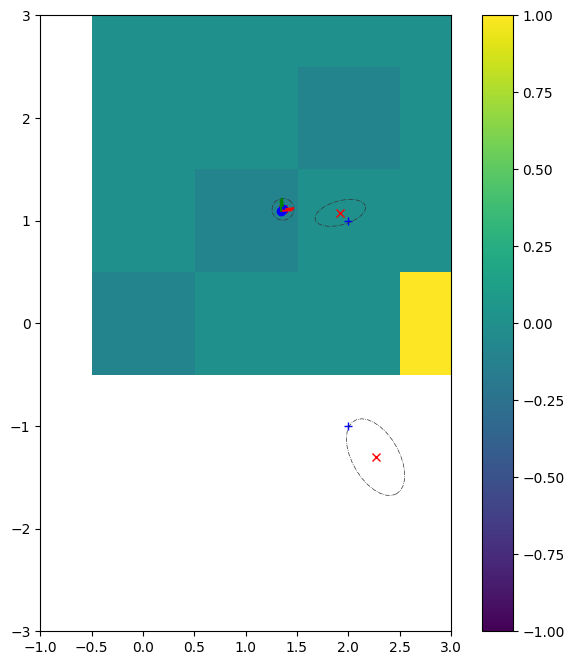

[ 1.53881673  0.46118327  1.41919451  0.58080549  0.6852195  -0.6852195
  1.96826158  0.03173842  1.31342418  0.68657582  0.69232262 -0.69232262
  1.53316528  0.46683472  1.69187711  0.30812289  0.31551563 -0.31551563]


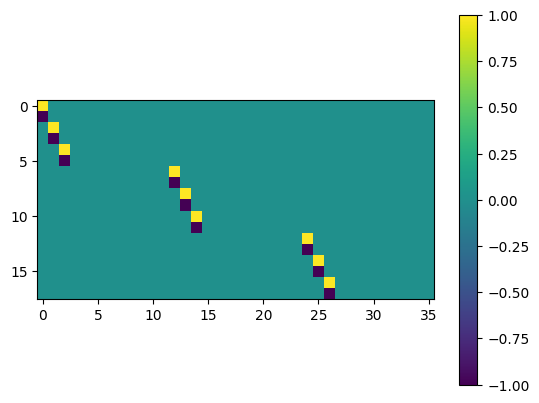

In [59]:
# Example of u_min & u_max
v_min = -1 # linear velocity
v_max = 1
w_min = 0 # angular velocity
w_max = 0

u_min_max = [[v_min,v_max],
             [v_min,v_max],
             [w_min,w_max]]

def equality_constraint(vars, x_init):
    """returns a 1D array of equality constraints

    Args:
        vars (_type_): _description_
    """
    X_DIM = x_init.shape[0]
    U_DIM = POSE_DIM
    DIM = U_DIM+X_DIM
    TOTAL_DIM = len(vars)
    n_pass = int(len(vars)/DIM)

    # equality constraints involving the state
    state_cons = []
    state_cons_jac = []
    x_prev = x_init
    for i_pass in range(n_pass):
        # u comes first
        u = vars[i_pass*DIM : i_pass*DIM+U_DIM]
        x = vars[i_pass*DIM+U_DIM : (i_pass+1)*DIM]

        x_next = state_transition(x_prev,u,noise=0,dt=DELTA_T)

        for k, (x_k, x_next_k) in enumerate(zip(x.flatten(),x_next.flatten())):
            # k ranges from 0 to X_DIM-1
            
            # append constraint
            state_cons.append(x_k-x_next_k)

            # jacobian for this constraint
            jac_this = np.zeros(TOTAL_DIM)
            if k<POSE_DIM: 
                # the first 3 constraints involves actual robot motion
                jac_this[i_pass*DIM+k] = -DELTA_T # derivative w.r.t u

            # jacobian terms involving x
            jac_this[i_pass*DIM+U_DIM+k] = 1
            if i_pass>0:
                jac_this[(i_pass-1)*DIM+U_DIM+k] = -1
            
            state_cons_jac.append(jac_this)

        x_prev = x

    state_cons = np.array(state_cons)
    state_cons_jac = np.array(state_cons_jac)

    return state_cons, state_cons_jac

def inequality_constraint(vars):
    X_DIM = x_init.shape[0]
    U_DIM = POSE_DIM
    DIM = U_DIM+X_DIM
    TOTAL_DIM = len(vars)
    n_pass = int(len(vars)/DIM)

    ineq_cons = []
    ineq_cons_jac = []

    for i_pass in range(n_pass):
        # u comes first
        u = vars[i_pass*DIM : i_pass*DIM+U_DIM]

        for k in range(U_DIM):
            min_val, max_val = u_min_max[k]

            # >= v_min
            ineq_cons.append(u[k]-min_val)
            jac_this = np.zeros(TOTAL_DIM)
            jac_this[i_pass*DIM+k] = 1
            ineq_cons_jac.append(jac_this)

            # <= v_max
            ineq_cons.append(max_val-u[k])
            jac_this = np.zeros(TOTAL_DIM)
            jac_this[i_pass*DIM+k] = -1
            ineq_cons_jac.append(jac_this)

    ineq_cons = np.array(ineq_cons)
    ineq_cons_jac = np.array(ineq_cons_jac)

    return ineq_cons, ineq_cons_jac

# test constraints
np.random.seed(1)
x_init = np.random.rand(9)
vars = np.random.rand((3+9)*3)
eq_cons = lambda vars : equality_constraint(vars, x_init)[0]
eq_cons_jac = lambda vars : equality_constraint(vars, x_init)[1]
ineq_cons = lambda vars : inequality_constraint(vars)[0]
ineq_cons_jac = lambda vars : inequality_constraint(vars)[1]

%matplotlib inline
cons = eq_cons(vars)
print(cons,'\n',cons.shape)
plt.imshow(eq_cons_jac(vars))
plt.colorbar()
plt.show()

print(ineq_cons(vars))
plt.imshow(ineq_cons_jac(vars))
plt.colorbar()
plt.show()


### Define planner

In [60]:
def planner(x_init,P_init,n_pass):

    if len(x_init.shape)>1:
        x_init = x_init.flatten()

    eq_cons = lambda vars : equality_constraint(vars, x_init)[0]
    eq_cons_jac = lambda vars : equality_constraint(vars, x_init)[1]
    ineq_cons = lambda vars : inequality_constraint(vars)[0]
    ineq_cons_jac = lambda vars : inequality_constraint(vars)[1]
    
    equality_cons = {'type': 'eq',
           'fun' : eq_cons,
           'jac' : eq_cons_jac}
    
    inequality_cons = {'type': 'ineq',
            'fun' : ineq_cons,
            'jac' : ineq_cons_jac}
    
    # construct init_guess, simply copy over x_init, and setting u to 0
    X_DIM = x_init.shape[0]
    U_DIM = POSE_DIM
    DIM = U_DIM+X_DIM
    init_guess = np.zeros(DIM*n_pass)
    for i_pass in range(n_pass):
        init_guess[i_pass*DIM+U_DIM:(i_pass+1)*DIM]=x_init
    
    res = minimize(loss_func,init_guess,
                   args=(x_init,P_init),
                   method="SLSQP",jac=True,
                   constraints=[equality_cons,inequality_cons],
                   options={'ftol': 1e-5, 'disp': True})
    
    print(f"optimization success: {res.success}")

    if res.success:
        # return the first control command
        u_opt = res.x[:U_DIM]
    else:
        u_opt = None

    return u_opt, res

### Simulation loop

In [61]:
# define a model to sample scene points 3D location given the pixel value
def pixel_to_3d(ux,uy,robot_pose,zs_min=1.0,zs_max=5.0):
    # sample a zs
    zs_hat = zs_min + np.random.rand()*(zs_max-zs_min)

    xs_hat = (ux-PX)/FX*zs_hat
    ys_hat = (uy-PY)/FY*zs_hat
    Tcam_inv = cam_pose_matrix(robot_pose)
    xs,ys,zs = get_world_coord(np.array([xs_hat,ys_hat,zs_hat]),Tcam_inv)
    return xs,ys,zs

In [67]:
# define current robot pose and ground truth scene point location
robot_pose = [0,0,0]
scene_pt1_gt = [2.0,0.5,0.0]
scene_pt2_gt = [2.0,-1.0,0.0]
scene_pts = [scene_pt1_gt,scene_pt2_gt]

# get pixel value
ux1,uy1 = observation_model(robot_pose, scene_pt1_gt)
ux2,uy2 = observation_model(robot_pose, scene_pt2_gt)
print((ux1,uy1))
print((ux2,uy2))

# get 3d location beliefs
np.random.seed(12)
pt1_bel = pixel_to_3d(ux1,uy1,np.array(robot_pose))
pt2_bel = pixel_to_3d(ux2,uy2,np.array(robot_pose))
print(pt1_bel)
print(pt2_bel)

# construct initial state
x0 = np.array(robot_pose+[*pt1_bel]+[*pt2_bel])[:,np.newaxis]

# initialize P0, large variance for the scene points
P0 = np.diag([1e-3,1e-3,1e-3]+[10,10,10]*2)
# P0 = np.diag([0,0,0]+[.1,0.2,0.1]*2)


(-0.25, 0.0)
(0.5, 0.0)
(1.6166513695186895, 0.40416284237967237, 0.0)
(3.960198786061619, -1.9800993930308095, 0.0)


In [63]:
# test optimizer
u,res = planner(x0,P0,n_pass=10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.191006488563465
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 8
optimization success: True


In [68]:
%matplotlib qt

from util import plot_scene_pt_ground_truth, plot_robot

max_timestep = 1000

# create new plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.set_xlim([-1,3])
ax.set_ylim([-3,3])
plot_scene_pt_ground_truth(scene_pts)
fig.show()

np.random.seed(123)
x = x0
x_actual=x0
P = P0
plot_ind_lst = ["r",0,1]
plot_handle_mu = [None]*len(plot_ind_lst)
plot_handle_cov = [None]*len(plot_ind_lst)

# visualize initial states
for k,id in enumerate(plot_ind_lst):
    mu,sigma = get_mu_sigma(x,P,id)
    plot_handle_mu[k],plot_handle_cov[k] = plot_cov(plot_handle_mu[k],
        plot_handle_cov[k],ax,mu,sigma)

use_default_policy = False
first_flip=5

vy = 1.0
robot_bel_plot = None
robot_actual_plot = None
for t in range(max_timestep):
    
    robot_bel_plot = plot_robot(ax, robot_bel_plot, x[0],x[1],x[2])
    robot_actual_plot = plot_robot(ax, robot_actual_plot, x_actual[0],
                                   x_actual[1],x_actual[2])

    # solve for u
    if use_default_policy:
        plt.pause(0.5)
        if t==first_flip:
            vy*=-1
        elif t-first_flip>0 and (t-first_flip)%(2*first_flip)==0:
            vy*=-1
        u = np.array([0,vy,0])[:,np.newaxis]
    else:
        plt.pause(0.001)
        u,res = planner(x,P,n_pass=10)
        print(u)
        if u is None:
            u = np.array([0,0,0])

    # carry out control
    x_actual = state_transition(x_actual,u,noise=PROCESS_NOISE_COV,dt=DELTA_T)

    # get new observation
    n_landmark = get_landmark_number(x)
    robot_pose = get_robot_pose(x_actual)
    obs = []
    for i_landmark in range(n_landmark):
        scene_pt = scene_pts[i_landmark]
        y = observation_model(robot_pose,scene_pt,noise=OBS_NOISE_COV)
        # y = observation_model(robot_pose,scene_pt)
        print("====== obs ======")
        print(y)
        obs.append(y)
    
    # run EKF update
    x,P = ekf_update(x,P,u,obs)
    

    # visualize current result on the XY plane
    for k,id in enumerate(plot_ind_lst):
        mu,sigma = get_mu_sigma(x,P,id)
        plot_handle_mu[k],plot_handle_cov[k] = plot_cov(plot_handle_mu[k],
            plot_handle_cov[k],ax,mu,sigma)
        

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.283710160690248
            Iterations: 9
            Function evaluations: 20
            Gradient evaluations: 9
optimization success: True
[-1.00000000e+00  9.47487545e-01 -4.20551174e-17]
====== obs ======
(-0.33496145040139375, -0.05786002519685364)
====== obs ======
(0.6921065019387393, -0.24266792433930742)
Iteration limit reached    (Exit mode 9)
            Current function value: 6.8487440320110435
            Iterations: 100
            Function evaluations: 1006
            Gradient evaluations: 100
optimization success: False
None
====== obs ======
(-0.2548183190018832, -0.009470896893689114)
====== obs ======
(0.6699715497584616, -0.0638901996684651)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.170578324645553
            Iterations: 16
            Function evaluations: 29
            Gradient evaluations: 16
optimization success: True

KeyboardInterrupt: 

In [62]:
ux,uy = observation_model([0,0,np.pi/2],[1.0,1.0,0.0])
print(ux,uy)

0.9999999999999999 0.0


In [23]:
x = x0
x_next = state_transition(x,u,noise=PROCESS_NOISE_COV,dt=DELTA_T)
x_next

array([[ 0.01008343],
       [ 0.00627167],
       [-0.05134694],
       [ 0.54668369],
       [ 0.27334185],
       [ 0.72665815],
       [ 2.75843566],
       [-1.37921783],
       [-0.37921783]])

In [36]:
plt.imshow(P)

In [17]:
x

array([[-0.07911128],
       [-0.09181073],
       [-0.12924818],
       [ 1.04516439],
       [ 0.51873124],
       [ 0.53942201],
       [ 3.79662943],
       [-1.7742619 ],
       [-0.79898596]])

In [9]:
mu

array([0., 0., 0.])

In [19]:
P0

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1]])

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
fig.show()
h1=None
h2=None

mu,sigma = get_mu_sigma(x0,P0,ind=0)
h1,h2 = plot_cov(h1,h2,ax,mu,sigma)

for _ in range(10):
    plt.pause(0.1)
    
    mu,sigma = get_mu_sigma(x0,P0,ind=0)
    mu += np.array([0.1*_,0])
    h1,h2 = plot_cov(h1,h2,ax,mu,sigma)
    fig.canvas.flush_events()
    fig.canvas.draw()